## Importing Libraries + Sign In

In [43]:
from noaa_sdk import NOAA
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import requests
import time
from KalshiClientsBase import ExchangeClient
from KalshiClientsBase import HttpError

In [44]:
# logging in
username = MY_USERNAME
password = MY_PASSWORD
exchange_api_base = "https://trading-api.kalshi.com"
requests.post('https://trading-api.kalshi.com/v2/log_in')

exchange_client = ExchangeClient(exchange_api_base, username, password)
my_token = exchange_client.token
my_user_id = exchange_client.user_id

## Loading Markets

In [45]:
# getting market data
def json_to_df():
    url_chi = "https://trading-api.kalshi.com/trade-api/v2/markets?event_ticker=HIGHCHI&status=open"
    url_nyc = "https://trading-api.kalshi.com/trade-api/v2/markets?event_ticker=HIGHNY&status=open"

    headers = {
        "accept": "application/json",
        "Authorization": "Bearer " + my_token
    }

    response_chi = requests.get(url_chi, headers=headers).json()
    response_nyc = requests.get(url_nyc, headers=headers).json()

    temp = []
    for i in response_chi['markets']:
        temp.append([i['ticker'],i['ticker'].split('-')[0],i['ticker'].split('-')[1],i['ticker'].split('-')[2],i['yes_bid'],i['yes_ask'],i['no_ask'],i['no_bid'],i['liquidity']])
    for i in response_nyc['markets']:
        temp.append([i['ticker'],i['ticker'].split('-')[0],i['ticker'].split('-')[1],i['ticker'].split('-')[2],i['yes_bid'],i['yes_ask'],i['no_ask'],i['no_bid'],i['liquidity']])
    high_markets = pd.DataFrame(temp, columns = ['ticker','market','day','temp_submarket','yes_bid', 'yes_ask','no_ask','no_bid','liquidity'])

    return high_markets

## Cleaning Market Data

In [46]:
# this function takes in tickers of markets
# returns a df with the min and max contract temps
def defining_temp_ranges(weather_df):

    # initializing the min and max contract temps to unrealistic values
    weather_df['min_contract_temp'] = -999
    weather_df['max_contract_temp'] = 999

    temp_highs = []
    final_df  = pd.DataFrame()
    
    for i in weather_df['day'].unique():
        temp = weather_df[weather_df['day'] == i]

        for j in range(len(temp)):

            if temp.iloc[j,3][0] == 'B':
                # add .5 to max, subtract .5 from min
                temp.iloc[j,-1] = float(temp.iloc[j,3][1:]) + .5
                temp.iloc[j,-2] = float(temp.iloc[j,3][1:]) - .5

            if temp.iloc[j,3][0] == 'T':
                temp_highs.append(float(temp.iloc[j,3][1:]))
    
        for j in range(len(temp)):
            if temp.iloc[j,3][0] == 'T' and int(temp.iloc[j,3][1:]) == max(temp_highs):
                temp.iloc[j,-2] = float(temp.iloc[j,3][1:]) + 1
            elif temp.iloc[j,3][0] == 'T' and int(temp.iloc[j,3][1:]) == min(temp_highs):
                temp.iloc[j,-1] = float(temp.iloc[j,3][1:]) - 1

        temp_highs = []

        final_df  = pd.concat([final_df,temp])



    return final_df

## Getting Weather Preds

In [47]:
# celcius to fahrenheit function
def c_to_f(c):
    return c * 9 / 5 + 32

In [48]:
# function that gets the weather data from NOAA
def make_api_call(n, lat, long, type, MAX_RETRIES):
    try:
        response = n.points_forecast(lat, long, type=type)
        return response
    except Exception as e:
        if MAX_RETRIES > 0:
            MAX_RETRIES -= 1
            print("Error occurred. Retrying...")
            make_api_call(n, lat, long, type)
        else:
            print("Maximum retries exceeded. Quitting.")
            raise e

In [49]:
# initializing the NOAA object
n = NOAA()

# getting the chicago forecast as a dictionary
new_chi = make_api_call(n, 41.7953, -87.72453, 'forecastGridData', MAX_RETRIES = 25)
# storing todays and tomorrows max temperature in a tuple
chi_preds = (round(c_to_f(new_chi['properties']['maxTemperature']['values'][0]['value'])),round(c_to_f(new_chi['properties']['maxTemperature']['values'][1]['value'])))
# displaying the tuple
print(chi_preds)

# getting the new york forecast as a dictionary
new_nyc = make_api_call(n, 40.703242, -73.923323, 'forecastGridData', MAX_RETRIES = 25)
# storing todays and tomorrows max temperature in a tuple
nyc_preds = (round(c_to_f(new_nyc['properties']['maxTemperature']['values'][0]['value'])),round(c_to_f(new_nyc['properties']['maxTemperature']['values'][1]['value'])))
# displaying the tuple
print(nyc_preds)

(31, 35)
(43, 45)


## Understanding Today's and Tomorrow's Forecast

### New York

In [50]:
# get temperature values for the next few days in new_nyc
nyc_high_plot = []
for i in range(30):
    nyc_high_plot.append([new_nyc['properties']['temperature']['values'][i]['validTime'],round(c_to_f(new_nyc['properties']['temperature']['values'][i]['value']))])
nyc_high_plot = pd.DataFrame(nyc_high_plot, columns = ['date','temp'])
# plot it

In [51]:
nyc_high_plot.head(25)
nyc_high_plot['date'] = nyc_high_plot['date'].str.split('+', expand = True)[0]
nyc_high_plot['date'] = pd.to_datetime(nyc_high_plot['date'])
# create a new column which is the hours away from the current time
nyc_high_plot['hours_away'] = round((nyc_high_plot['date'] - datetime.datetime.now()).dt.total_seconds() / 3600)

In [52]:
# get the date for tomorrow
tmrw = datetime.date.today() + datetime.timedelta(days=2)
tmrw = pd.to_datetime(tmrw)
print(tmrw)
# only include nyc_high_plot['date'] where the date is tomorrow or earlier
nyc_high_plot = nyc_high_plot[nyc_high_plot['date'] <= tmrw]

2023-01-23 00:00:00


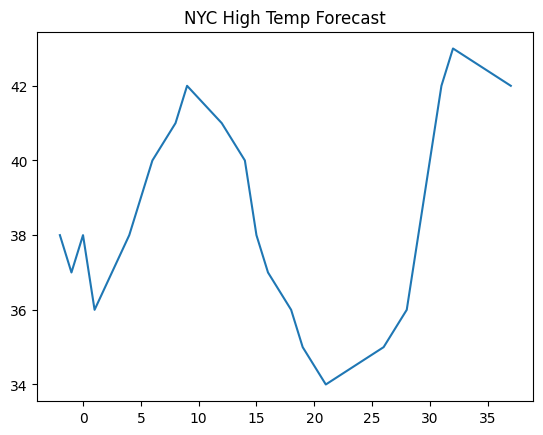

In [53]:
# plotting the high temperature forecast for NYC
plt.title('NYC High Temp Forecast')
plt.plot(nyc_high_plot['hours_away'],nyc_high_plot['temp'])

In [54]:
# get temperature values for the next few days in new york
nyc_high_plot

,date,temp,hours_away
0,2023-01-21 08:00:00,38,-2.0
1,2023-01-21 09:00:00,37,-1.0
2,2023-01-21 10:00:00,38,0.0
3,2023-01-21 11:00:00,36,1.0
4,2023-01-21 14:00:00,38,4.0
5,2023-01-21 15:00:00,39,5.0
6,2023-01-21 16:00:00,40,6.0
7,2023-01-21 18:00:00,41,8.0
8,2023-01-21 19:00:00,42,9.0
9,2023-01-21 22:00:00,41,12.0


### Chicago

In [55]:
# same thing as above but for chicago
chi_high_plot = []
for i in range(30):
    chi_high_plot.append([new_chi['properties']['temperature']['values'][i]['validTime'],round(c_to_f(new_chi['properties']['temperature']['values'][i]['value']))])
chi_high_plot = pd.DataFrame(chi_high_plot, columns = ['date','temp'])


In [56]:
chi_high_plot['date'] = chi_high_plot['date'].str.split('+', expand = True)[0]
chi_high_plot['date'] = pd.to_datetime(chi_high_plot['date'])
# create a new column which is the hours away from the current time
chi_high_plot['hours_away'] = round((chi_high_plot['date'] - datetime.datetime.now()).dt.total_seconds() / 3600)
# only include chi_high_plot['date'] where the date is tomorrow or earlier
chi_high_plot = chi_high_plot[chi_high_plot['date'] <= tmrw]

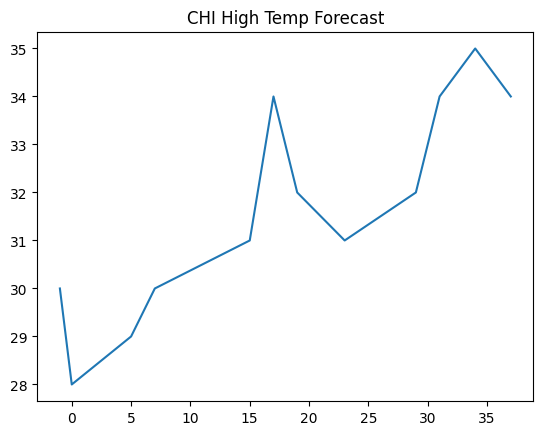

In [57]:
# plot it
plt.title('CHI High Temp Forecast')
plt.plot(chi_high_plot['hours_away'],chi_high_plot['temp'])

In [58]:
chi_high_plot.head(25)

,date,temp,hours_away
0,2023-01-21 09:00:00,30,-1.0
1,2023-01-21 10:00:00,28,0.0
2,2023-01-21 15:00:00,29,5.0
3,2023-01-21 17:00:00,30,7.0
4,2023-01-22 01:00:00,31,15.0
5,2023-01-22 03:00:00,34,17.0
6,2023-01-22 05:00:00,32,19.0
7,2023-01-22 09:00:00,31,23.0
8,2023-01-22 15:00:00,32,29.0
9,2023-01-22 16:00:00,33,30.0


## Calling the Get Markets Function From Earlier

In [59]:
high_markets = json_to_df()
high_markets

,ticker,market,day,temp_submarket,yes_bid,yes_ask,no_ask,no_bid,liquidity
0,HIGHCHI-23JAN22-T38,HIGHCHI,23JAN22,T38,3,7,97,93,45489
1,HIGHCHI-23JAN22-T31,HIGHCHI,23JAN22,T31,3,7,97,93,45489
2,HIGHCHI-23JAN22-B37.5,HIGHCHI,23JAN22,B37.5,13,18,87,82,13023
3,HIGHCHI-23JAN22-B35.5,HIGHCHI,23JAN22,B35.5,27,32,73,68,11764
4,HIGHCHI-23JAN22-B33.5,HIGHCHI,23JAN22,B33.5,27,32,73,68,11764
5,HIGHCHI-23JAN22-B31.5,HIGHCHI,23JAN22,B31.5,13,18,87,82,13023
6,HIGHCHI-23JAN21-T38,HIGHCHI,23JAN21,T38,1,6,99,94,67330
7,HIGHCHI-23JAN21-T31,HIGHCHI,23JAN21,T31,0,3,100,97,59636
8,HIGHCHI-23JAN21-B37.5,HIGHCHI,23JAN21,B37.5,3,6,97,94,165585
9,HIGHCHI-23JAN21-B35.5,HIGHCHI,23JAN21,B35.5,24,29,76,71,217708


In [60]:
chi_raw = defining_temp_ranges(high_markets[high_markets['market'] == 'HIGHCHI'])

/var/folders/x3/c5r72npn637bt_0n3yw_rmgw0000gn/T/ipykernel_53881/3842233716.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_df['min_contract_temp'] = -999
/var/folders/x3/c5r72npn637bt_0n3yw_rmgw0000gn/T/ipykernel_53881/3842233716.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_df['max_contract_temp'] = 999


In [61]:
nyc_raw = defining_temp_ranges(high_markets[high_markets['market'] == 'HIGHNY'])

/var/folders/x3/c5r72npn637bt_0n3yw_rmgw0000gn/T/ipykernel_53881/3842233716.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_df['min_contract_temp'] = -999
/var/folders/x3/c5r72npn637bt_0n3yw_rmgw0000gn/T/ipykernel_53881/3842233716.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_df['max_contract_temp'] = 999


## Cleaned DataFrame

In [62]:
high_markets = pd.concat([chi_raw, nyc_raw], axis=0)
high_markets

,ticker,market,day,temp_submarket,yes_bid,yes_ask,no_ask,no_bid,liquidity,min_contract_temp,max_contract_temp
0,HIGHCHI-23JAN22-T38,HIGHCHI,23JAN22,T38,3,7,97,93,45489,39,999
1,HIGHCHI-23JAN22-T31,HIGHCHI,23JAN22,T31,3,7,97,93,45489,-999,30
2,HIGHCHI-23JAN22-B37.5,HIGHCHI,23JAN22,B37.5,13,18,87,82,13023,37,38
3,HIGHCHI-23JAN22-B35.5,HIGHCHI,23JAN22,B35.5,27,32,73,68,11764,35,36
4,HIGHCHI-23JAN22-B33.5,HIGHCHI,23JAN22,B33.5,27,32,73,68,11764,33,34
5,HIGHCHI-23JAN22-B31.5,HIGHCHI,23JAN22,B31.5,13,18,87,82,13023,31,32
6,HIGHCHI-23JAN21-T38,HIGHCHI,23JAN21,T38,1,6,99,94,67330,39,999
7,HIGHCHI-23JAN21-T31,HIGHCHI,23JAN21,T31,0,3,100,97,59636,-999,30
8,HIGHCHI-23JAN21-B37.5,HIGHCHI,23JAN21,B37.5,3,6,97,94,165585,37,38
9,HIGHCHI-23JAN21-B35.5,HIGHCHI,23JAN21,B35.5,24,29,76,71,217708,35,36


## Plotting The Live Markets

In [79]:
# sorting high_markets by market and day
high_markets = high_markets.sort_values(by=['market','day']).reset_index(drop=True)

In [106]:
# creating a dictionary of dataframes, one for each market and day (four total)
fourths = len(high_markets) // 4
dataframes = {}
df_names = []
for i in range(4):
    subset = high_markets.iloc[i*fourths:(i+1)*fourths].sort_values(by='max_contract_temp').reset_index(drop=True)
    market_name = subset.iloc[0]['market']
    day_name = subset.iloc[0]['day']
    dataframes[market_name+'_'+day_name] = subset
    df_names.append(market_name+'_'+day_name)


Market: HIGHCHI_23JAN21


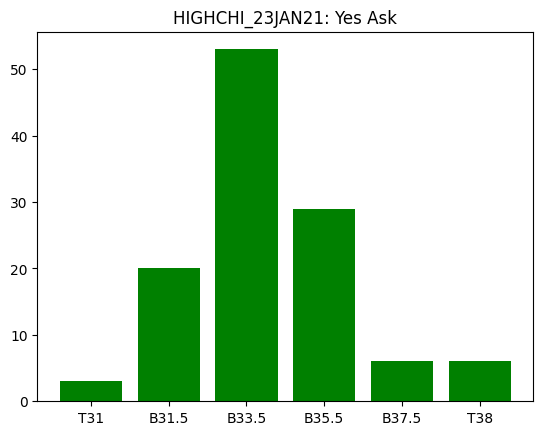

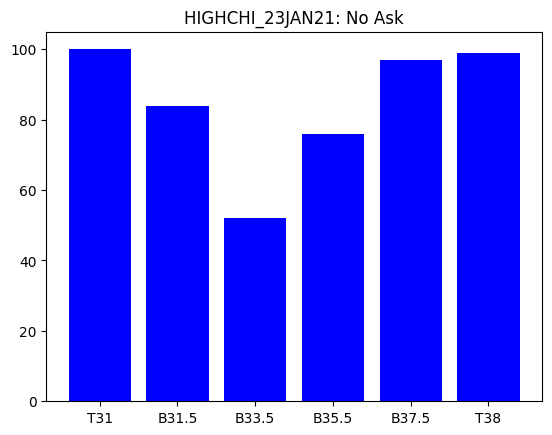

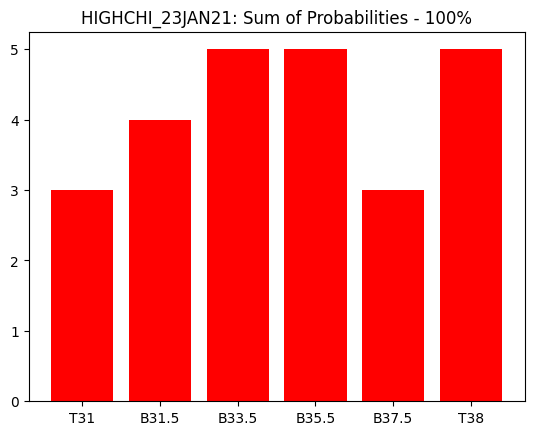

Market: HIGHCHI_23JAN22


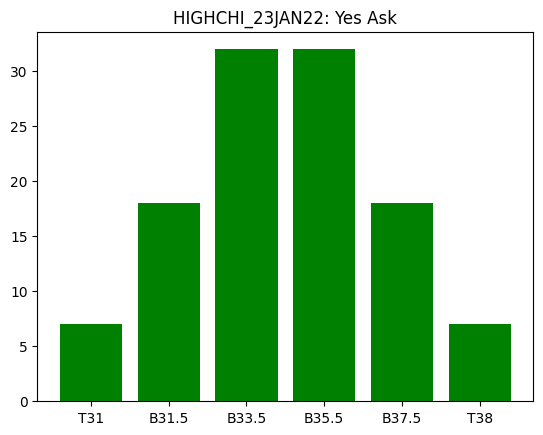

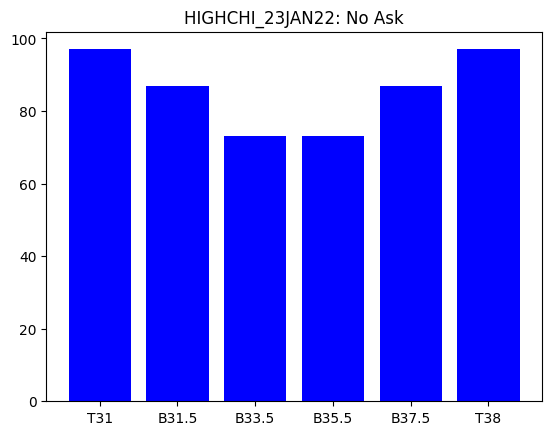

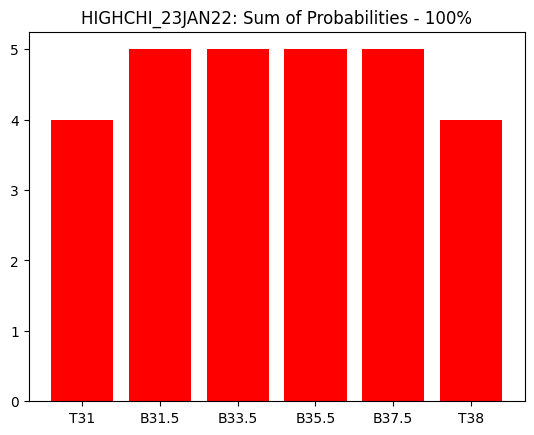

Market: HIGHNY_23JAN21


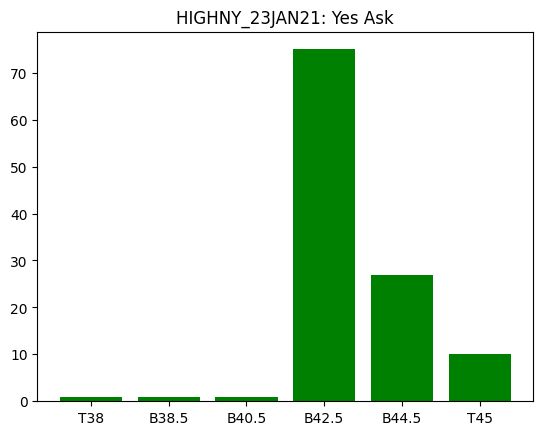

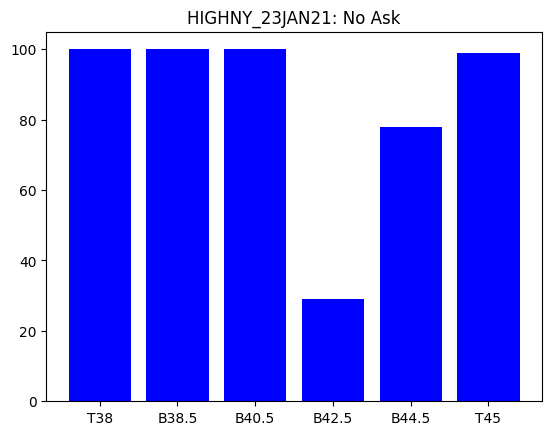

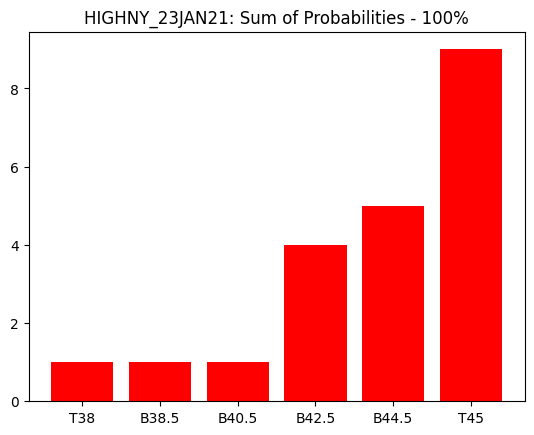

Market: HIGHNY_23JAN22


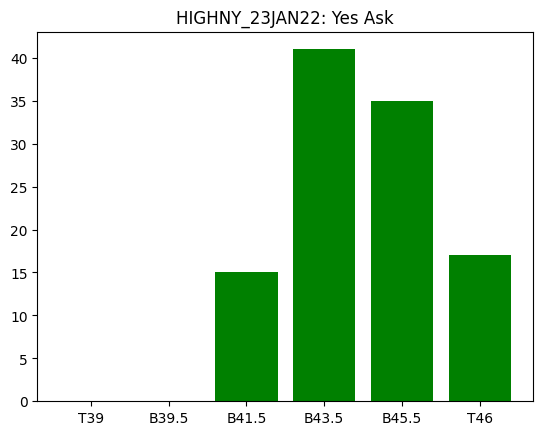

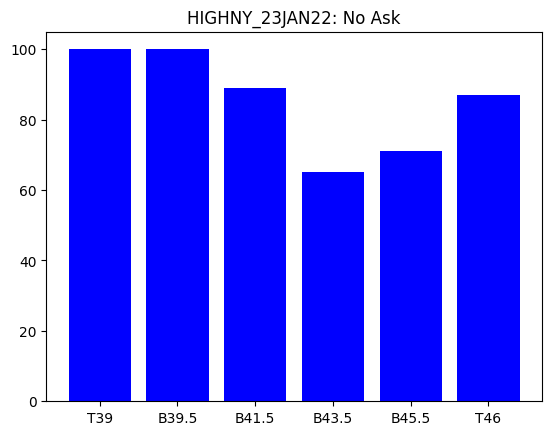

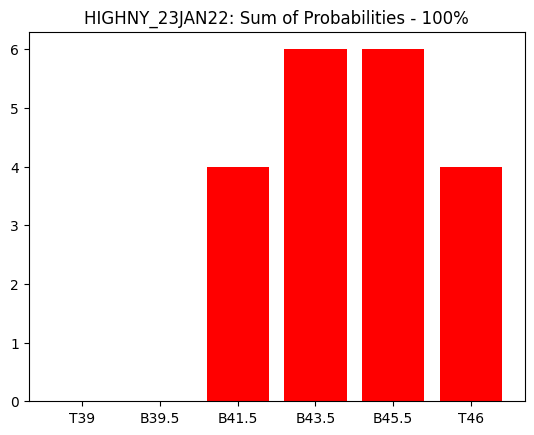

In [114]:
# plotting the live markets
for i in df_names:
    print('Market:', i)
    # plot print(dataframes[i])
    plt.title(i + ': Yes Ask')
    plt.bar(dataframes[i]['temp_submarket'],dataframes[i]['yes_ask'], color = 'green')
    plt.show()

    plt.title(i + ': No Ask')
    plt.bar(dataframes[i]['temp_submarket'],dataframes[i]['no_ask'], color = 'blue')
    plt.show()

    plt.title(i + ': Sum of Probabilities - 100%')
    plt.bar(dataframes[i]['temp_submarket'],dataframes[i]['no_ask'] + dataframes[i]['yes_ask'] - 100, color = 'red')
    plt.show()
    
    
